In [1]:
%run tools.py

### Mu analyses - GAARDIAN

In [2]:
sample_set = "1244-VO-GH-YAWSON-VMF00149"
chroms = ['2L', '2R', '3L', '3R', 'X']

In [3]:
snps = {}
pos = {}

for chrom in chroms:
    
    snps[chrom], pos[chrom], metadata = load_arrays_and_metadata("../resources", sample_set, chrom)
    
metadata['location'] = metadata['location'].str.split(".").str.get(0)

### Genetic Diversity windowed

This is without a site filter

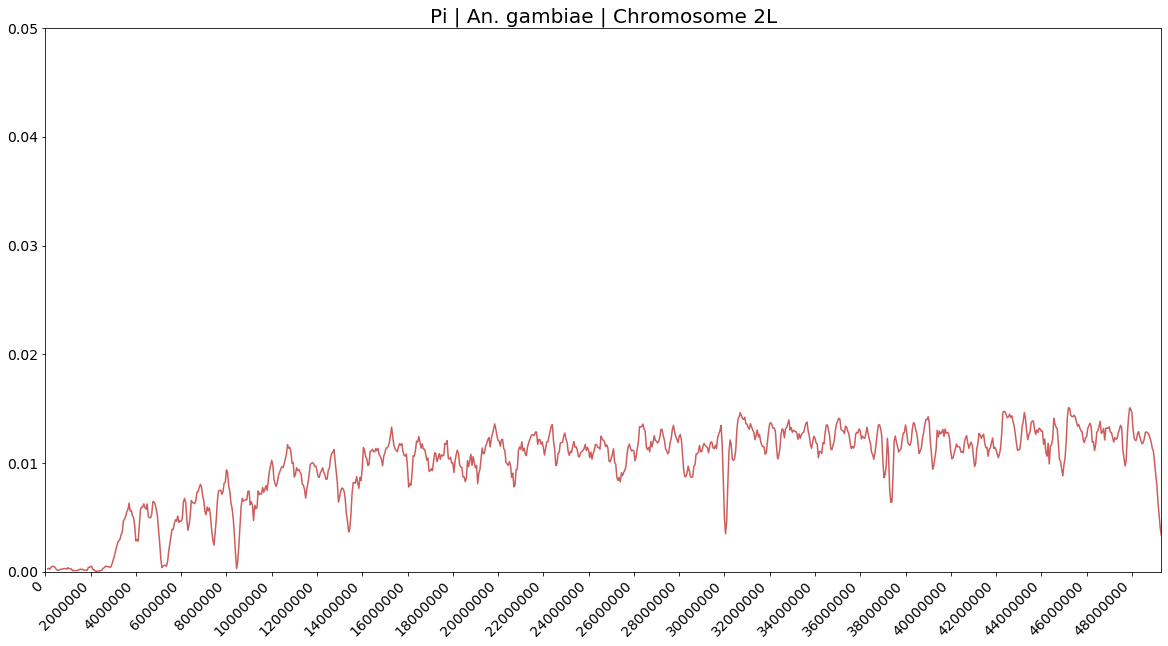

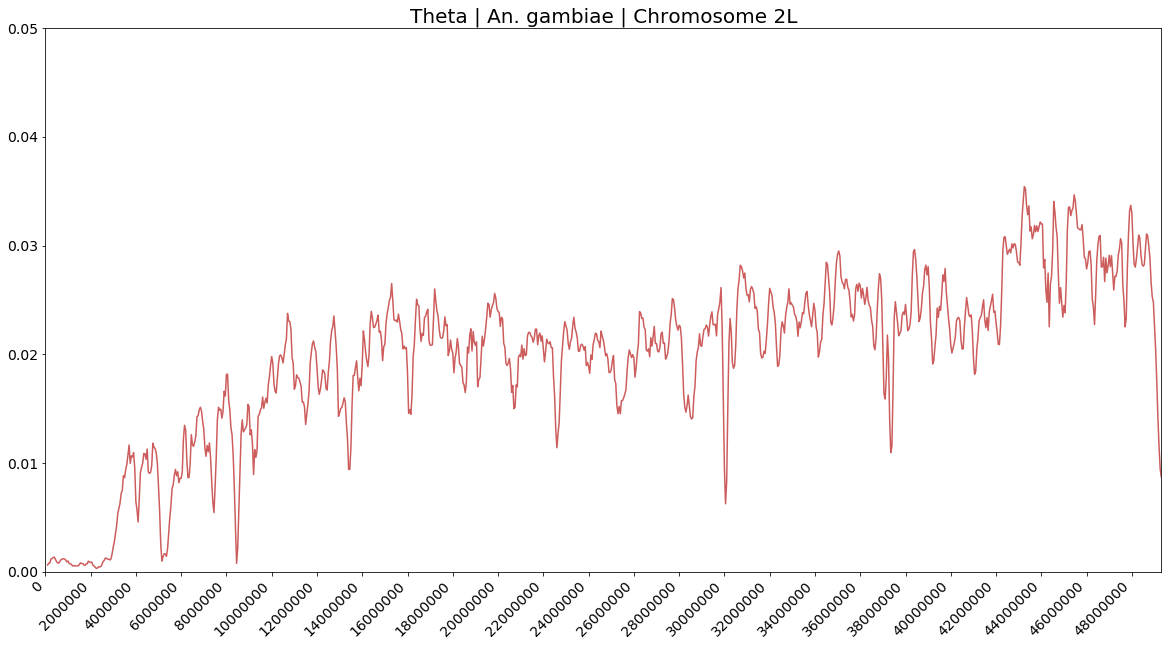

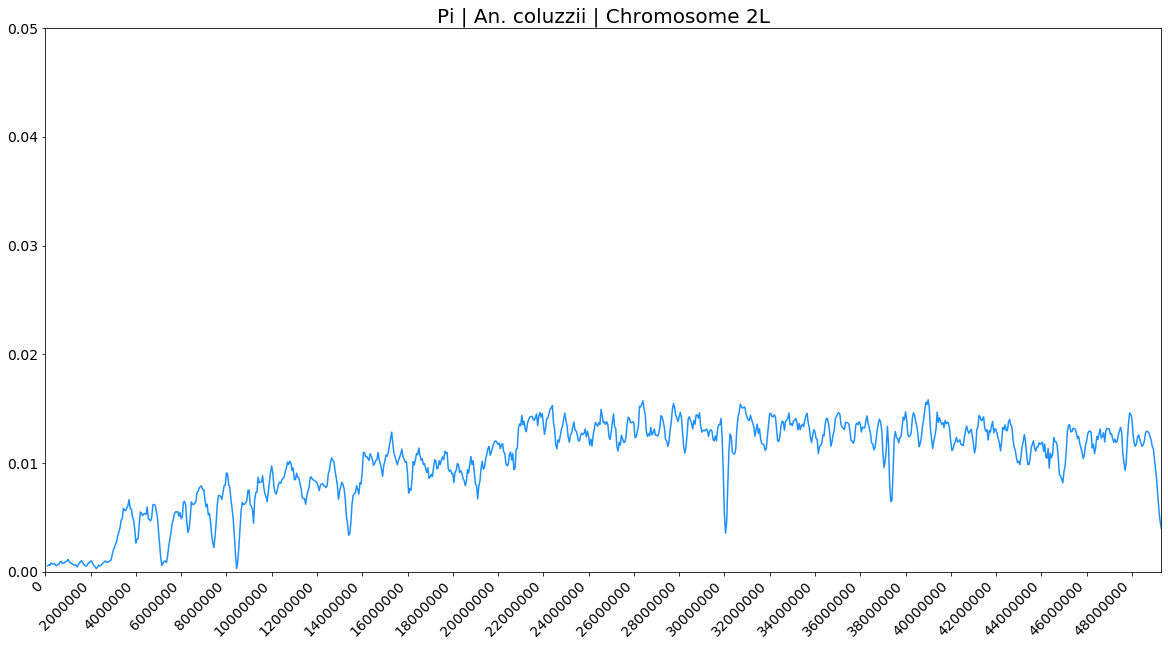

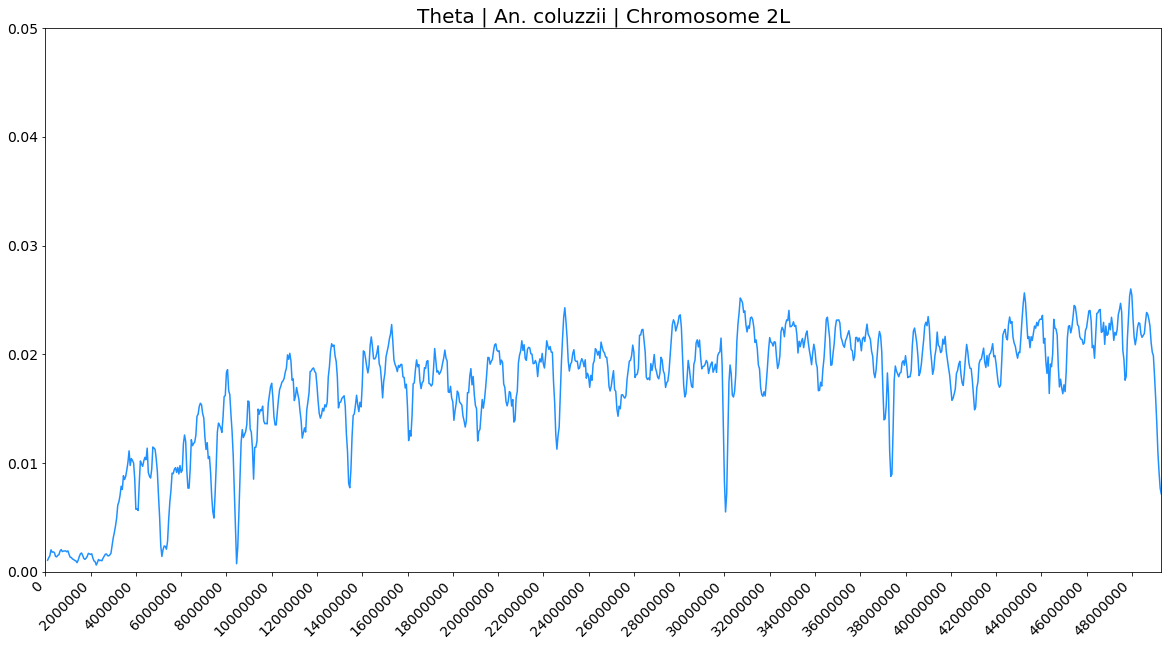

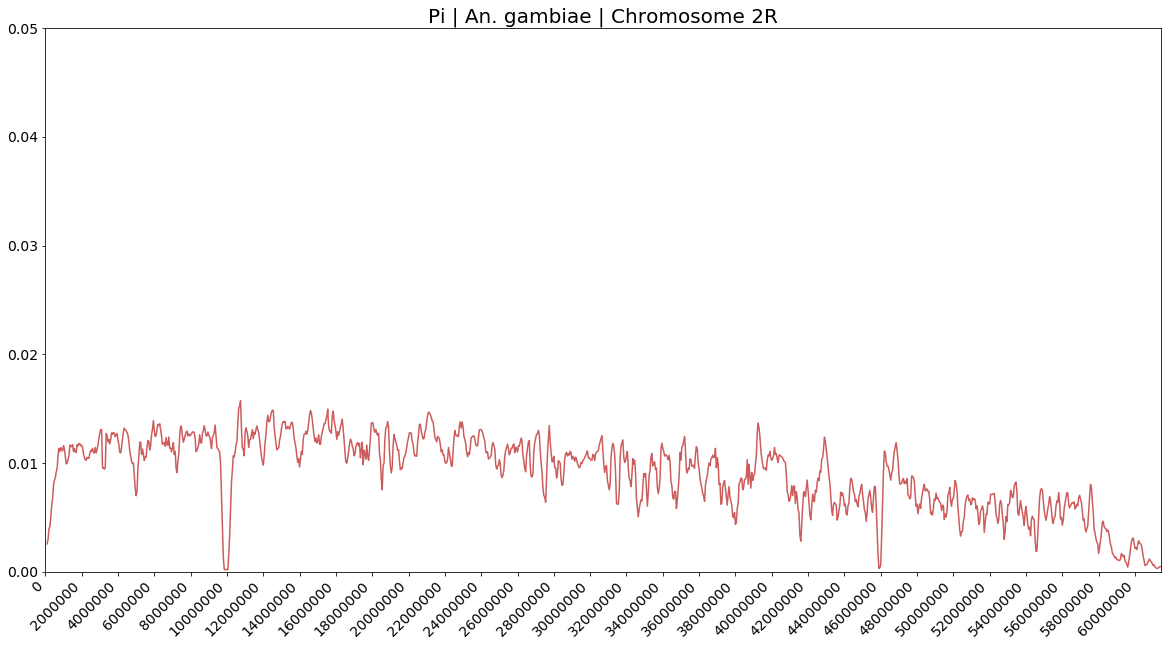

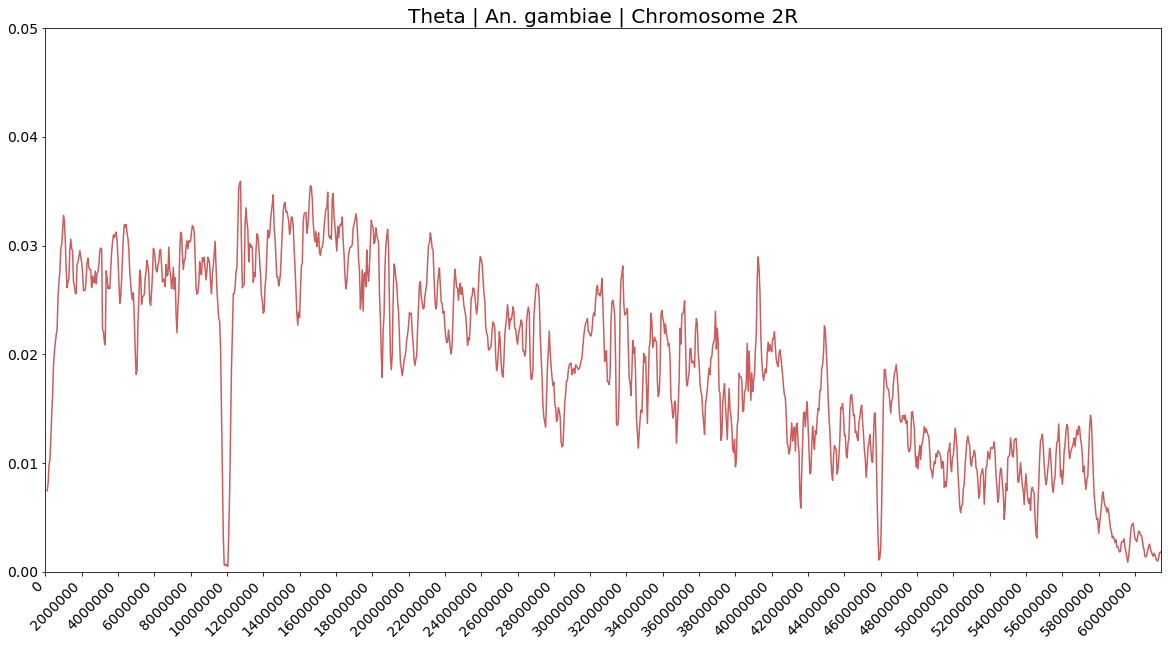

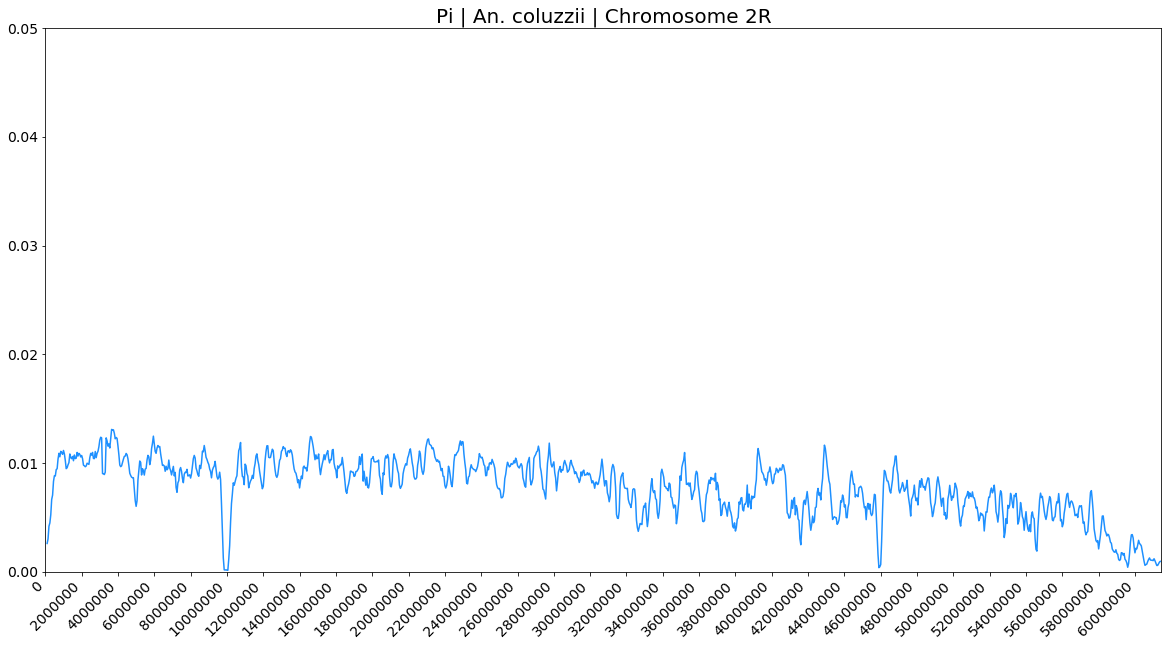

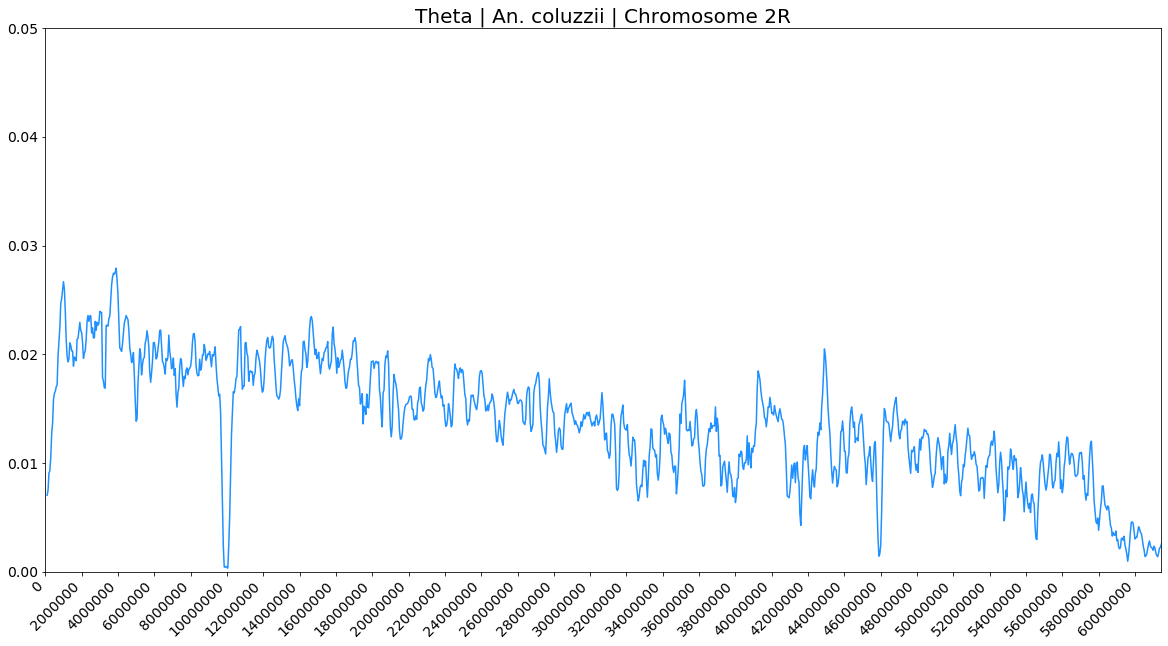

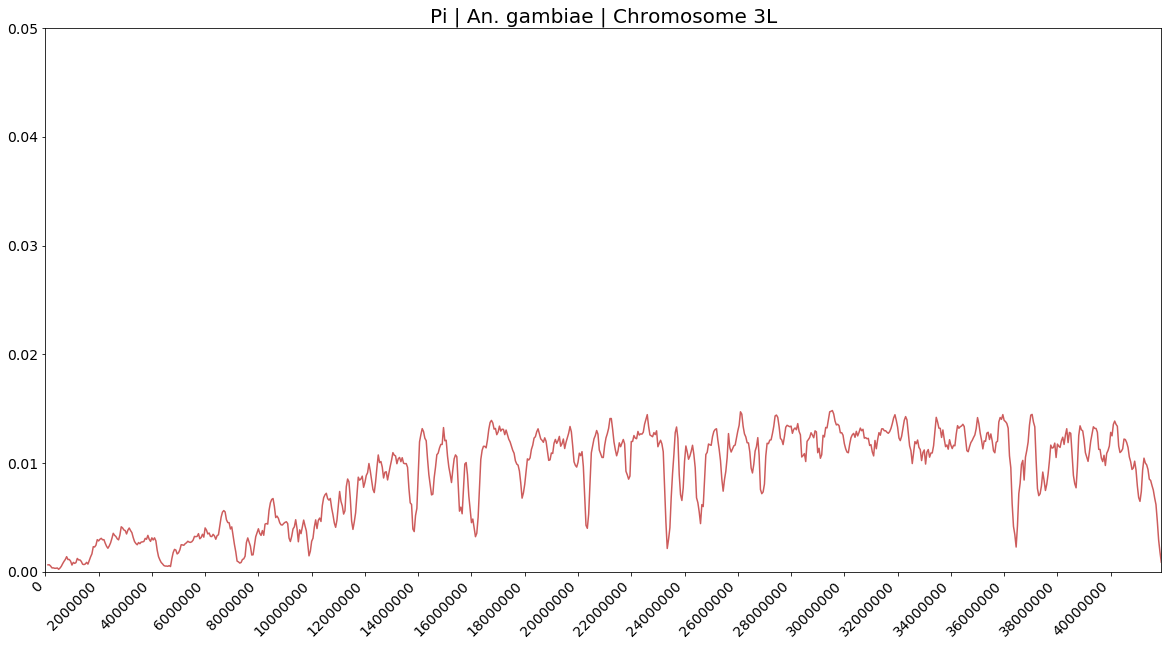

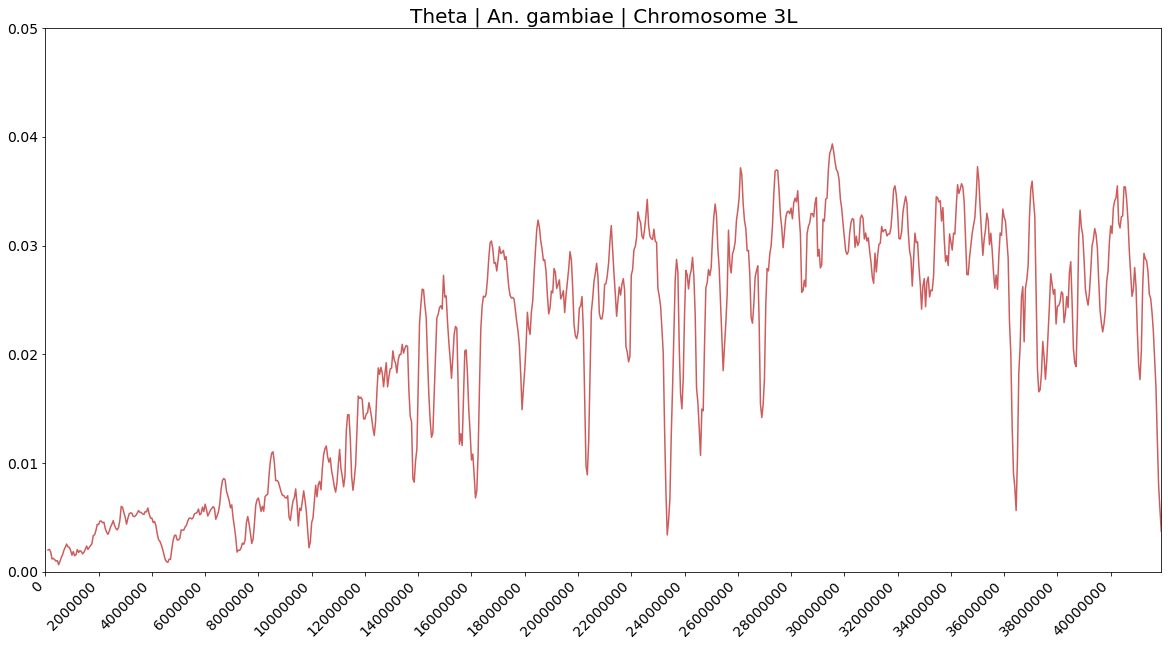

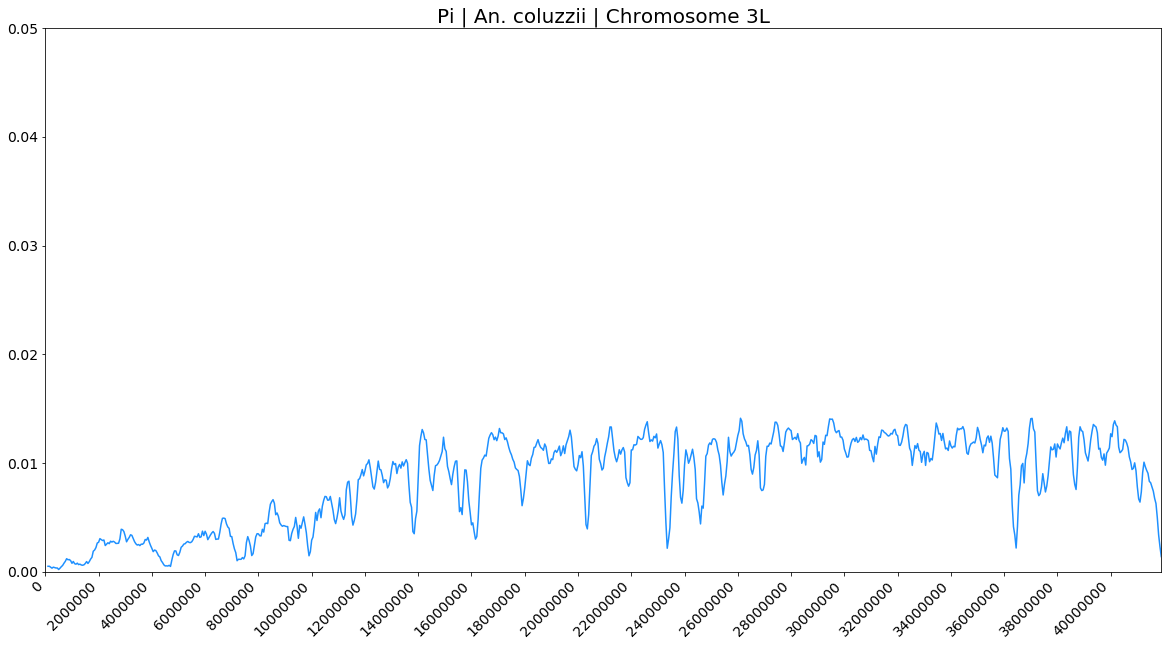

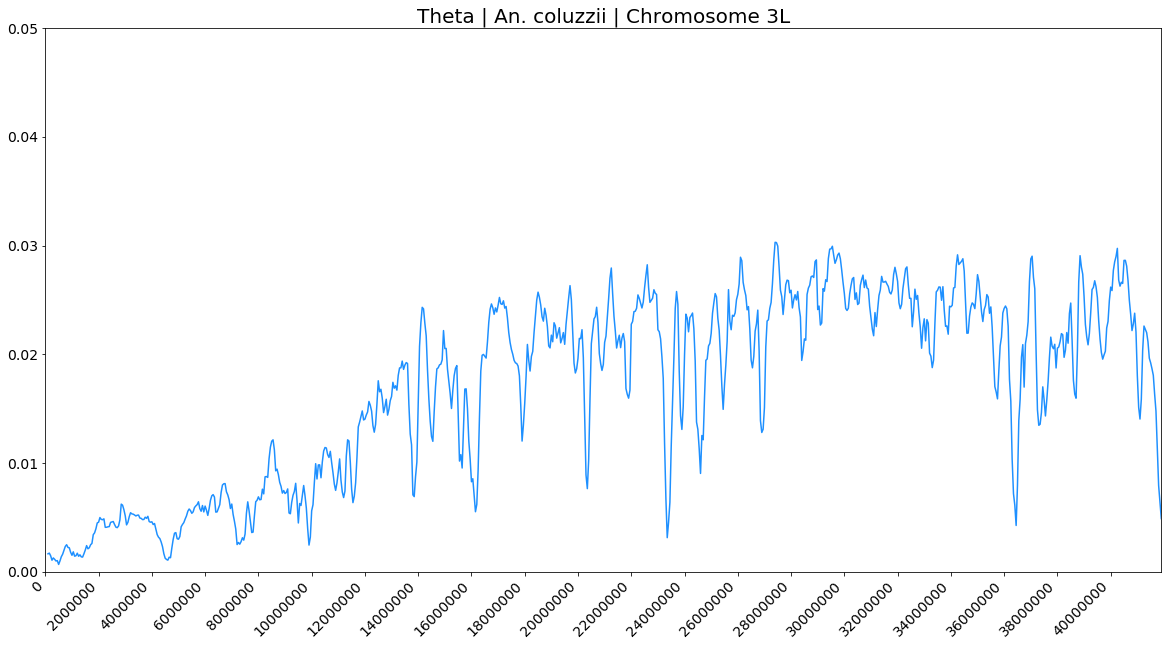

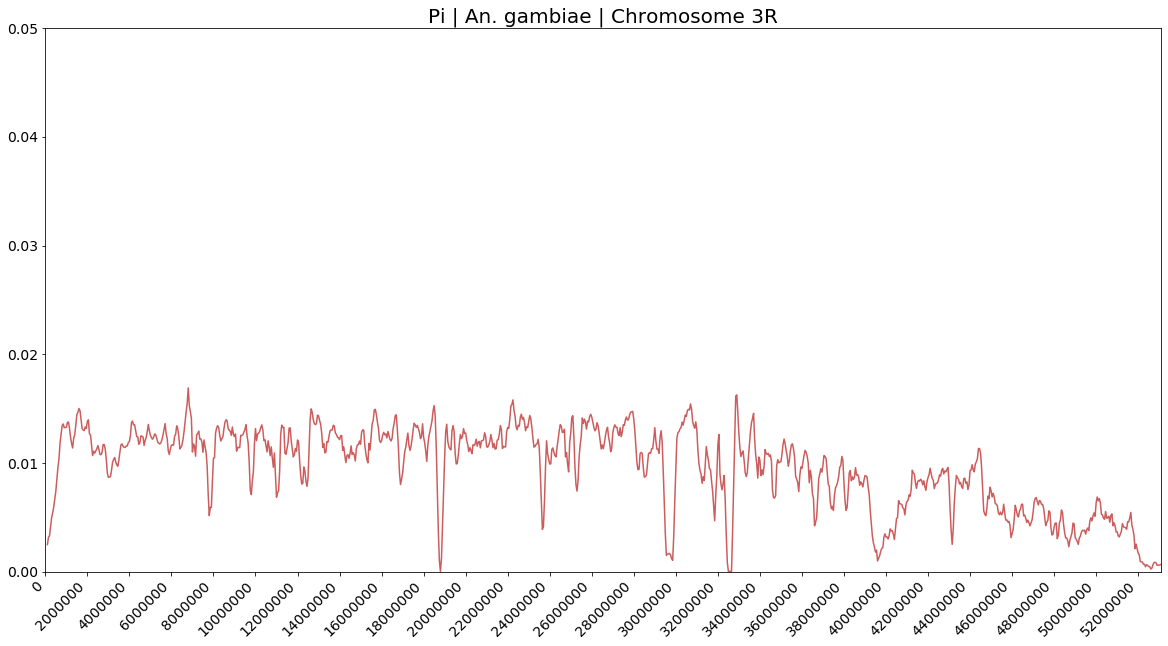

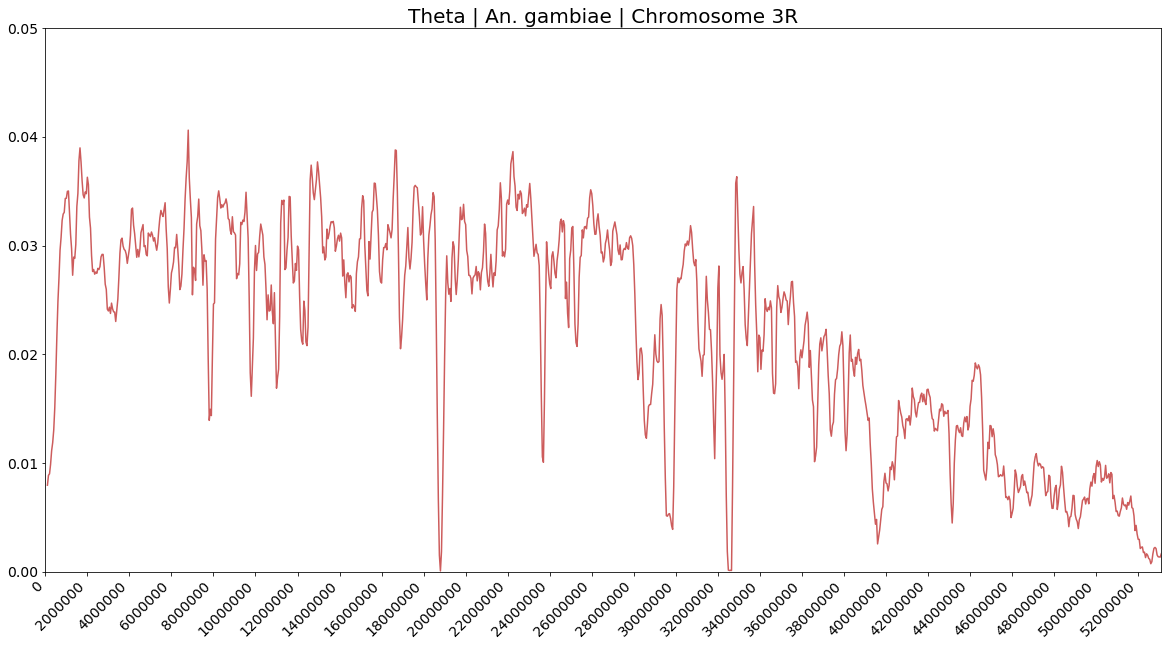

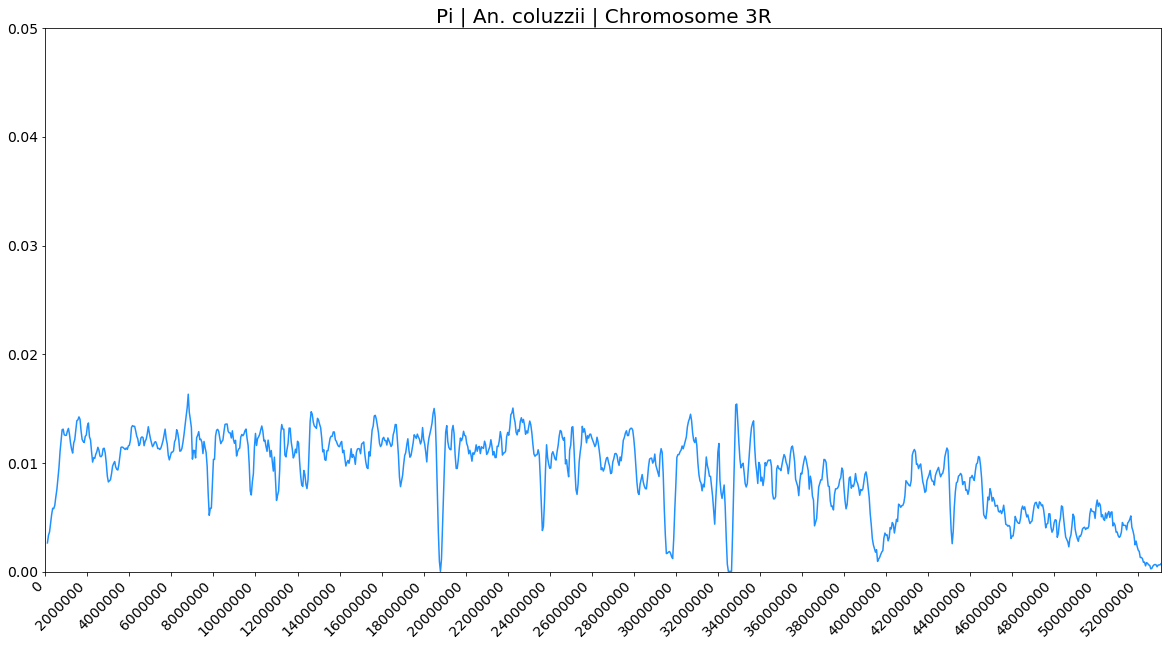

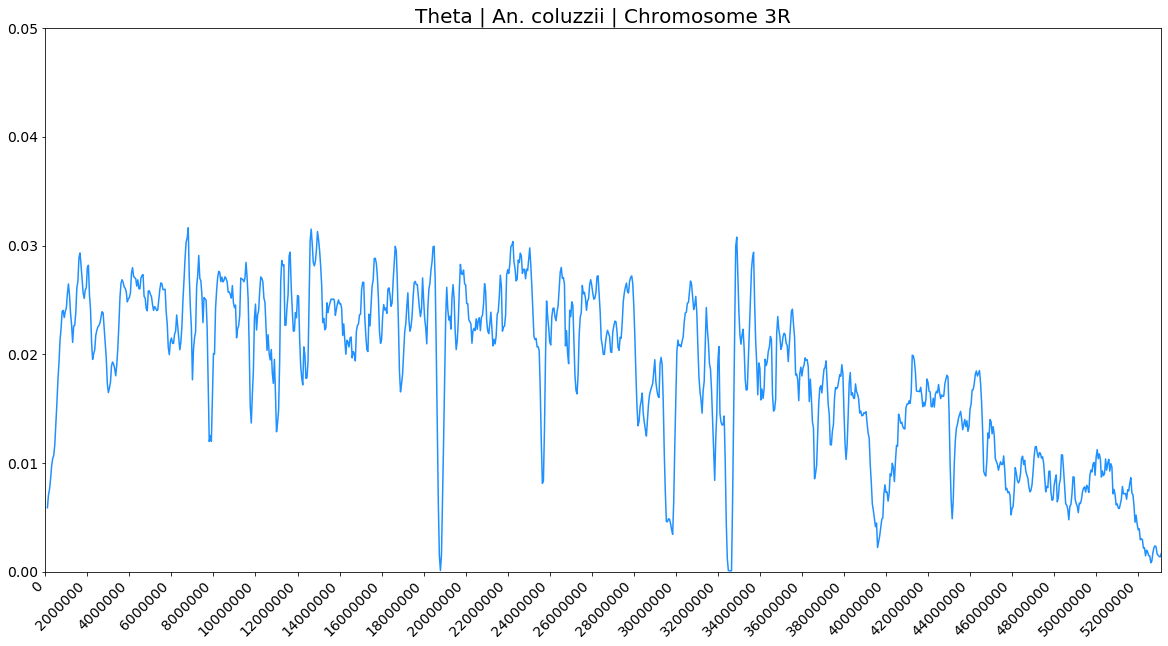

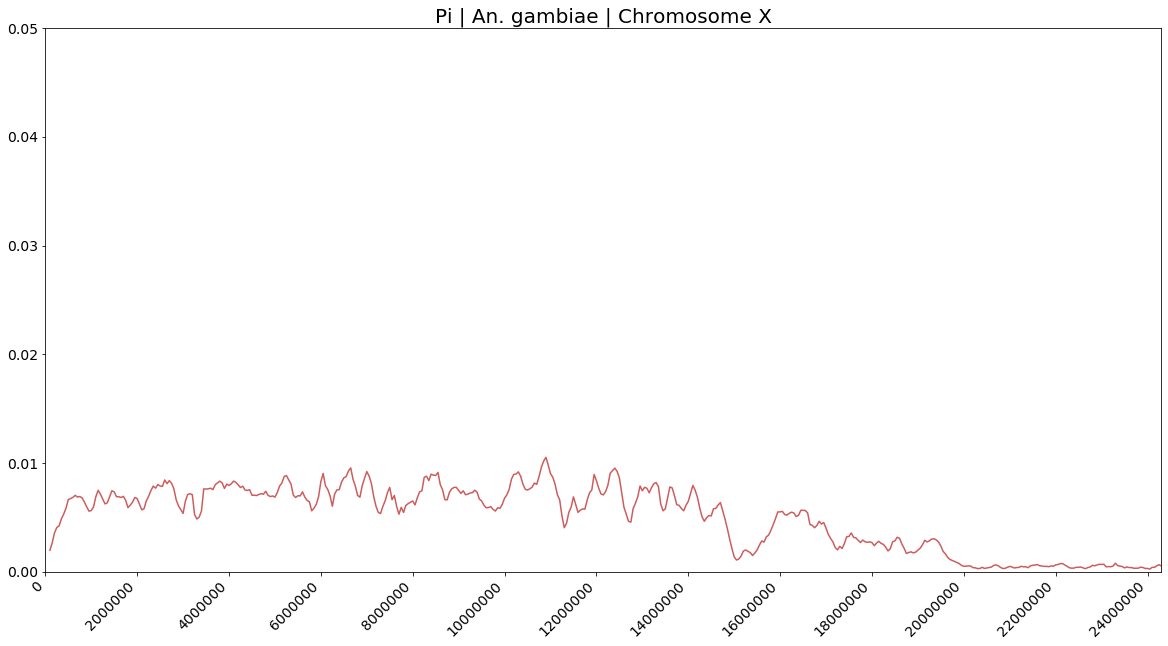

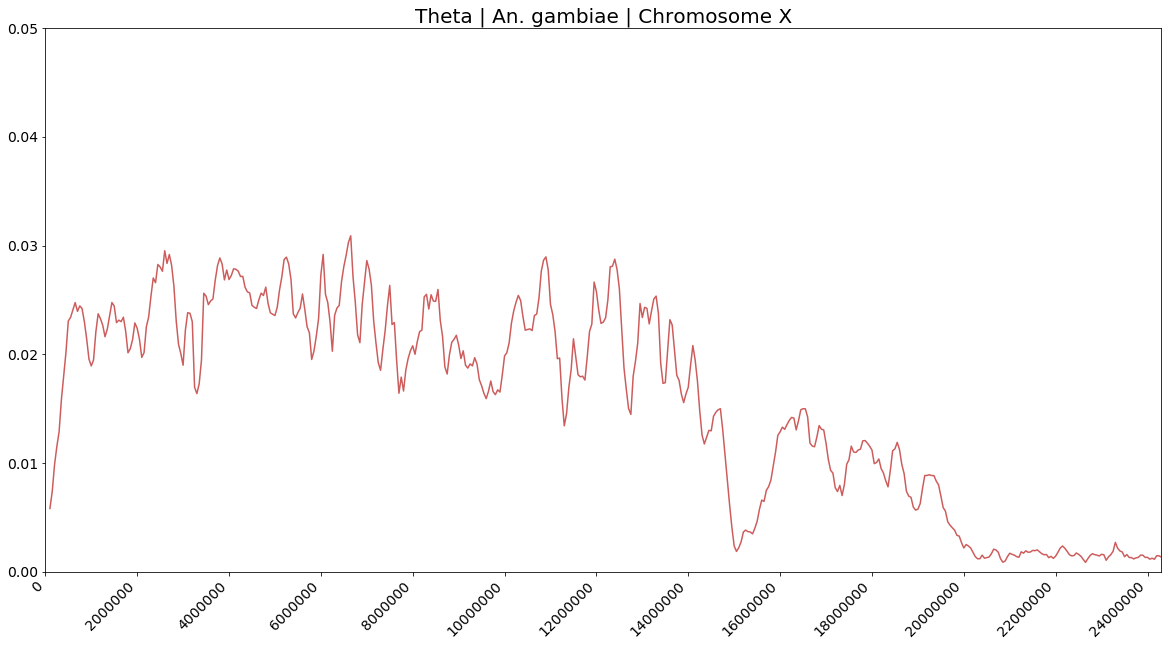

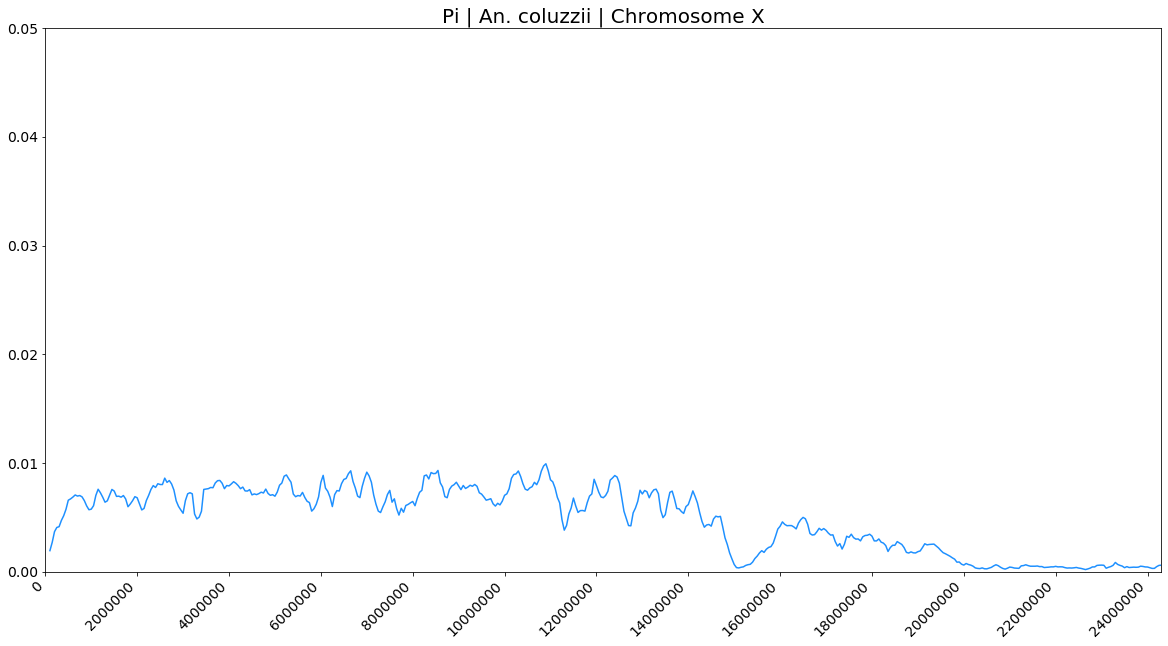

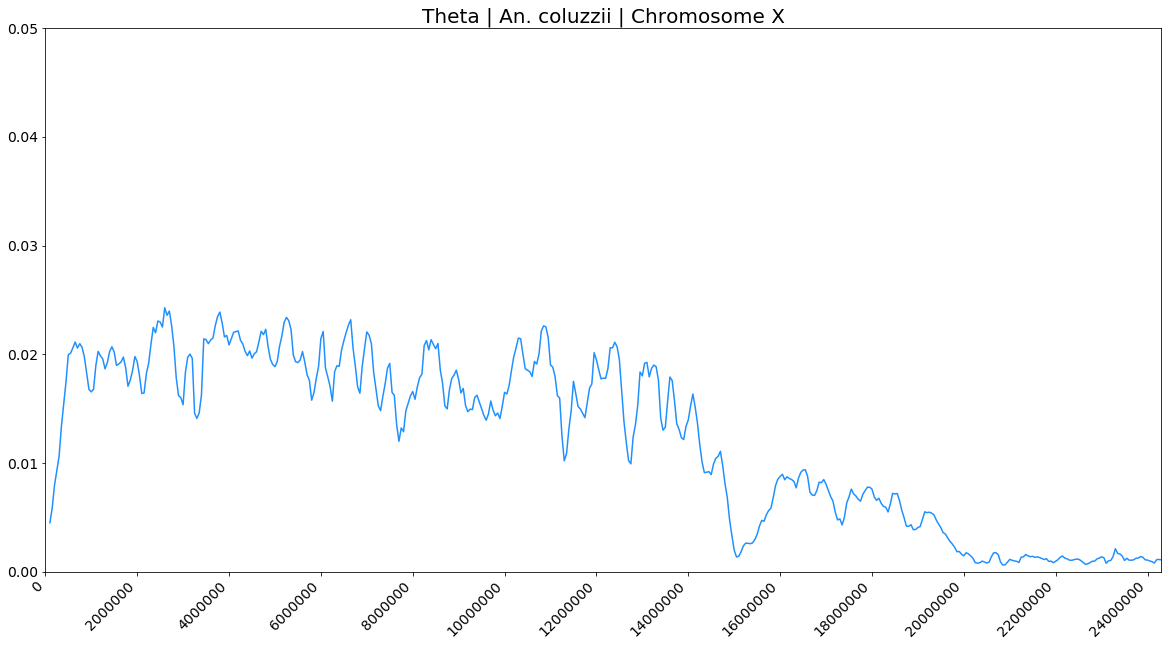

CPU times: user 2d 8h 9min 50s, sys: 18min 1s, total: 2d 8h 27min 52s
Wall time: 8h 30min 5s


In [5]:
%%time
pi = {}
theta = {}

for chrom in chroms:
    for sp in ['gambiae', 'coluzzii']:
        
        # Get boolean indices of species
        sp_bool = metadata['species_gambiae_coluzzii'] == sp 
        
        # Manipulate arrays
        geno = snps[chrom].compress(sp_bool, axis=1)
        
        if sp == 'coluzzii':
            inds = np.random.choice(geno.shape[1], size=100)
            geno = geno.take(inds, axis=1)
            
        ac = geno.count_alleles()
        
        size = 200000
        step = 50000
        # Calculate statistics 
        pi[chrom] = allel.windowed_diversity(pos[chrom], ac, size=size, step=step)
        midpoint = allel.moving_statistic(np.arange(0, pos[chrom][-1:]+step), np.median, size=size, step=step)

        saveAndPlot(statName="Pi", 
                    values=pi[chrom][0], 
                    midpoints=midpoint,
                    prefix="../results/diversity", 
                    species = sp,
                    chrom=chrom,
                    ylim=0.05, 
                   save=True)
        
        
        theta[chrom] = allel.windowed_watterson_theta(pos[chrom], ac, size=size, step=step)
        
        saveAndPlot(statName="Theta", 
            values=theta[chrom][0], 
            midpoints=midpoint,
            prefix="../results/diversity", 
            species = sp,
            chrom=chrom,
            ylim=0.05, 
           save=True)

#### Windowed Divergence (coluzzii v gambiae)

In [13]:
pos[chrom][:].max()

49364325

In [16]:
pos[chrom][-1:]

array([49364325], dtype=int32)

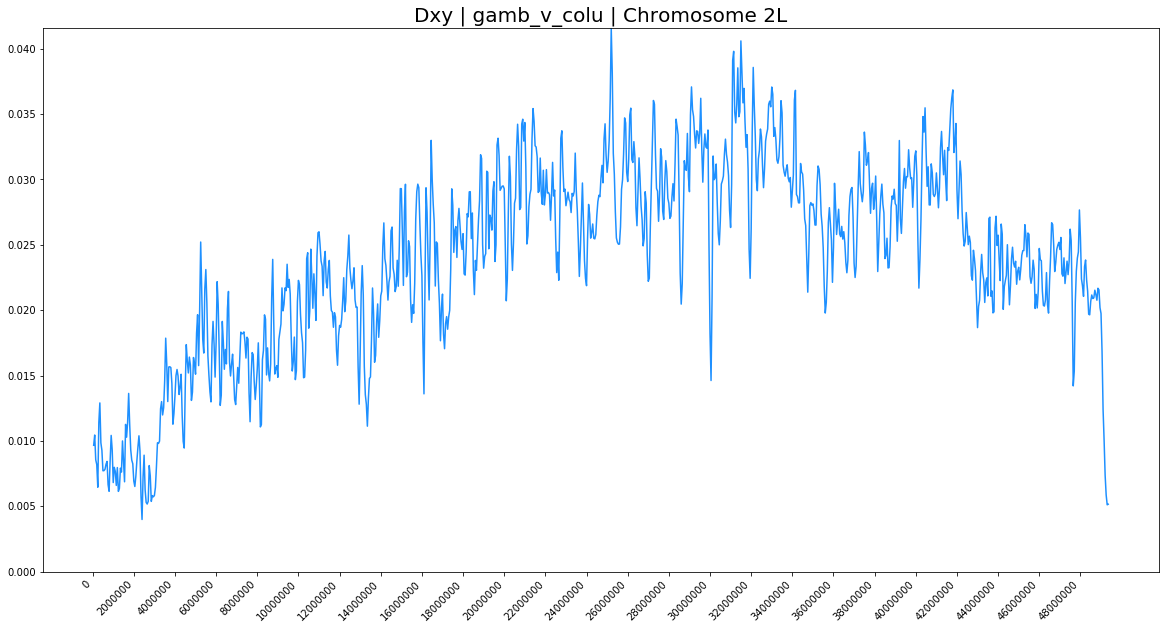

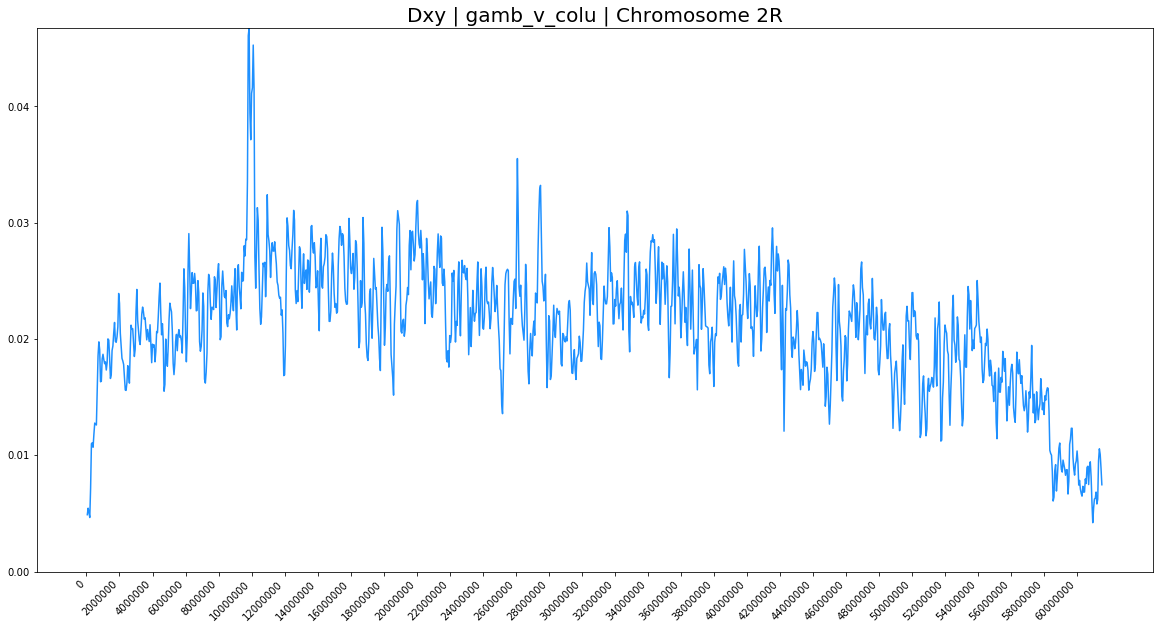

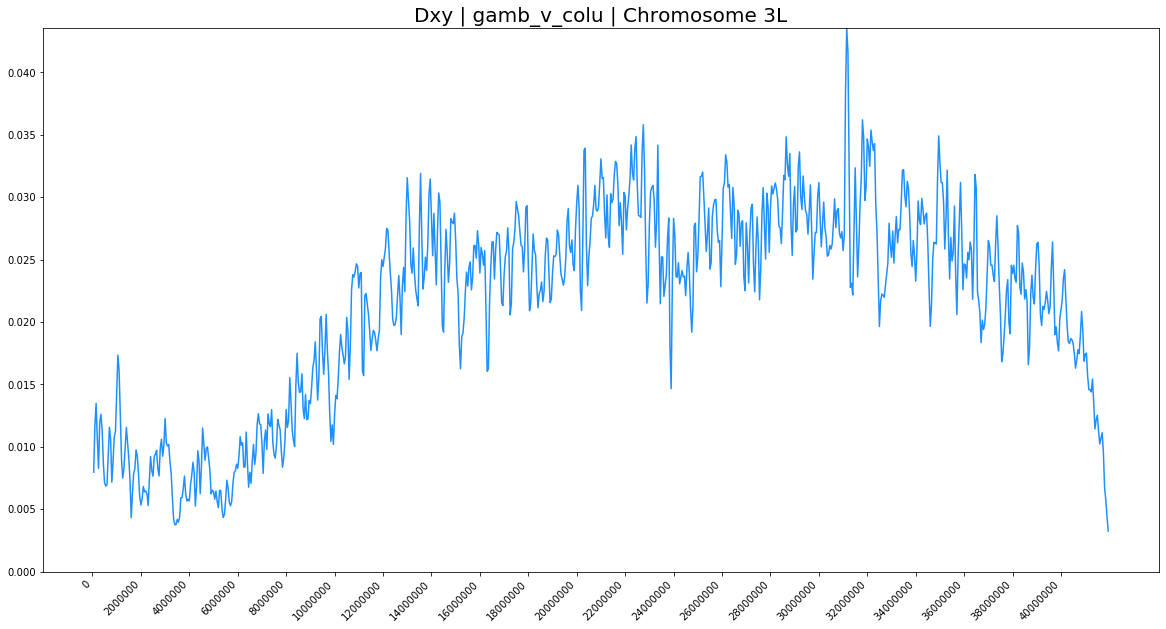

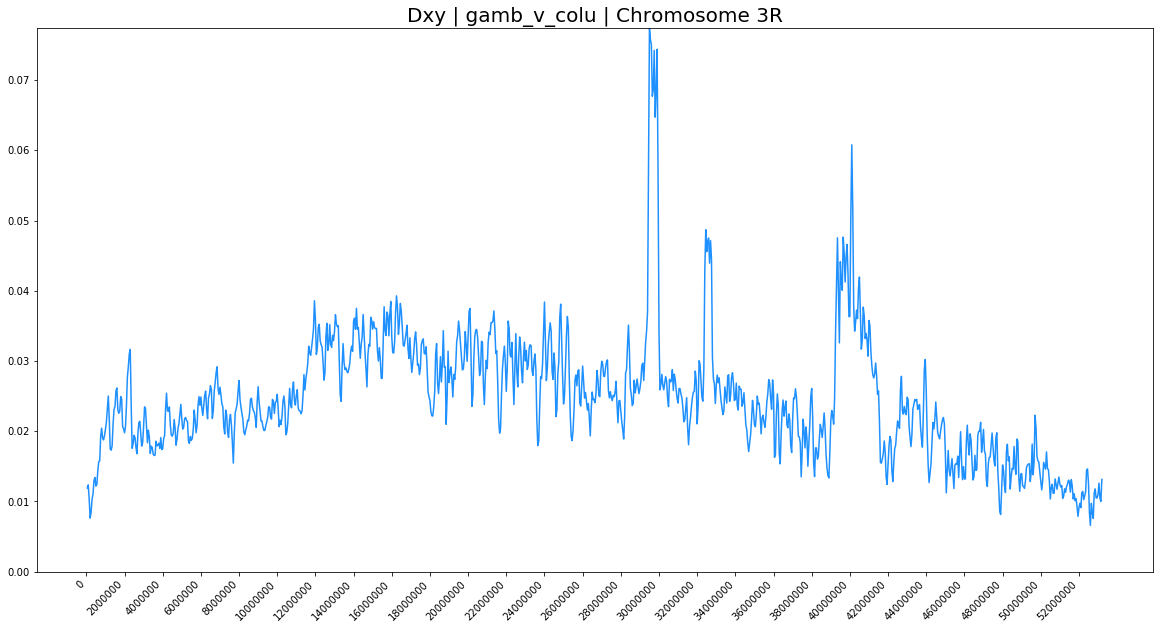

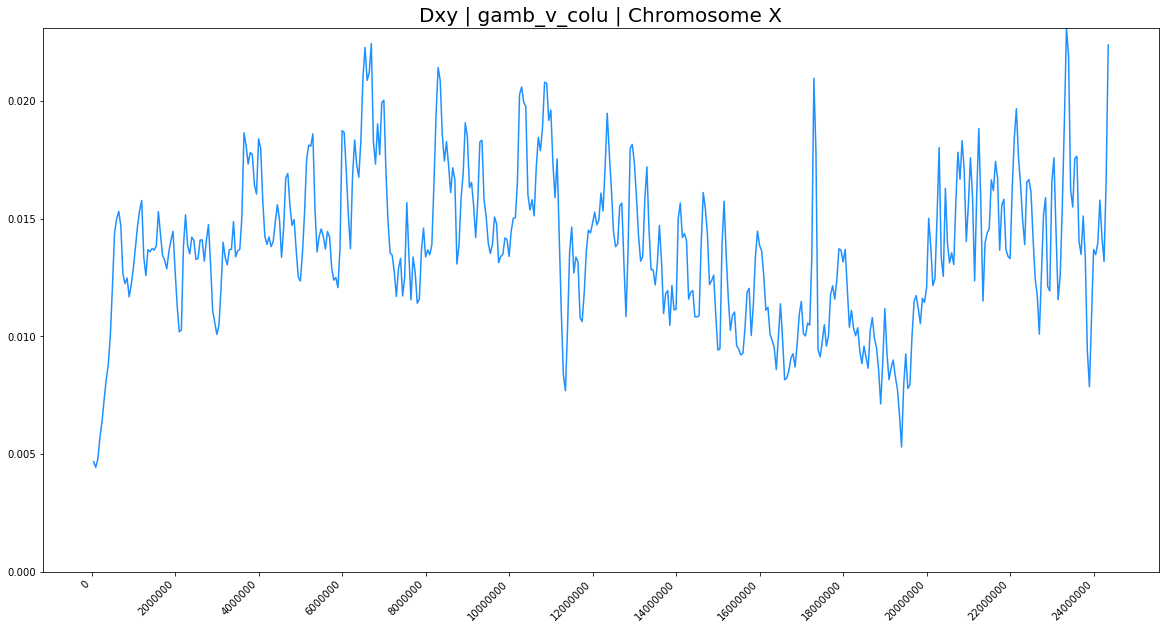

In [26]:
dxy = {}

for chrom in chroms:

    # Get boolean indices of species
    gamb_bool = metadata['species_gambiae_coluzzii'] == "gambiae" 
    colu_bool = metadata['species_gambiae_coluzzii'] == "coluzzii" 

    # Manipulate arrays
    ac_gamb = allel.GenotypeDaskArray(snps[chrom]).compress(gamb_bool, axis=1).count_alleles()
    ac_colu = allel.GenotypeDaskArray(snps[chrom]).compress(colu_bool, axis=1).count_alleles()

    # Calculate statistics 
    dxy[chrom] = allel.windowed_divergence(pos[chrom], ac_gamb, ac_colu, size=100000, step=50000)
    midpoint = allel.moving_statistic(np.arange(0, pos[chrom][-1:]), np.median, size=100000, step=50000)
    
    if midpoint.shape != dxy[chrom][0].shape:
        midpoint = allel.moving_statistic(np.arange(0, pos[chrom][-1:]+50000), np.median, size=100000, step=50000)
                                          
    saveAndPlot(statName="Dxy", 
                values=dxy[chrom][0], 
                midpoints=midpoint,
                prefix="../results/diversity", 
                species = "gamb_v_colu",
                chrom=chrom,
                ylim=0.02)